In [7]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

actions = ['scroll_up', 'scroll_down', 'like', "dislike", "none"]

dataset_base_path = "browser_dataset_v2"

In [10]:
dataset_names = [item for item in os.listdir(dataset_base_path) if 'seq' in item]
data = np.load(f'./{dataset_base_path}/{dataset_names[0]}')

for i in range(1, len(dataset_names)):
    data = np.concatenate([
        data,
        np.load(f'./{dataset_base_path}/{dataset_names[i]}')
    ], axis=0)

data.shape

(6873, 30, 100)

In [4]:
# dumb_array = np.random.rand(3, 4, 5)
# dumb_array

In [5]:
# dumb_array[:, :, :-1]

In [6]:
# dumb_array[:, 0, -1]

In [11]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6873, 30, 99)
(6873,)


In [12]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(6873, 5)

In [13]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6185, 30, 99) (6185, 5)
(688, 30, 99) (688, 5)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(128, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               116736    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 125,317
Trainable params: 125,317
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=80,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/80
191/194 [============================>.] - ETA: 0s - loss: 50.7915 - acc: 0.3055
Epoch 1: val_acc improved from -inf to 0.18459, saving model to models\model.h5
194/194 [==============================] - 4s 17ms/step - loss: 51.8382 - acc: 0.3049 - val_loss: 129.9068 - val_acc: 0.1846 - lr: 0.0010
Epoch 2/80
192/194 [============================>.] - ETA: 0s - loss: 50.7608 - acc: 0.3366
Epoch 2: val_acc improved from 0.18459 to 0.30959, saving model to models\model.h5
194/194 [==============================] - 3s 16ms/step - loss: 50.5573 - acc: 0.3365 - val_loss: 37.1822 - val_acc: 0.3096 - lr: 0.0010
Epoch 3/80
194/194 [==============================] - ETA: 0s - loss: 15.6140 - acc: 0.3363
Epoch 3: val_acc improved from 0.30959 to 0.47093, saving model to models\model.h5
194/194 [==============================] - 3s 15ms/step - loss: 15.6140 - acc: 0.3363 - val_loss: 6.7065 - val_acc: 0.4709 - lr: 0.0010
Epoch 4/80
193/194 [============================>.] - ETA: 0s - los

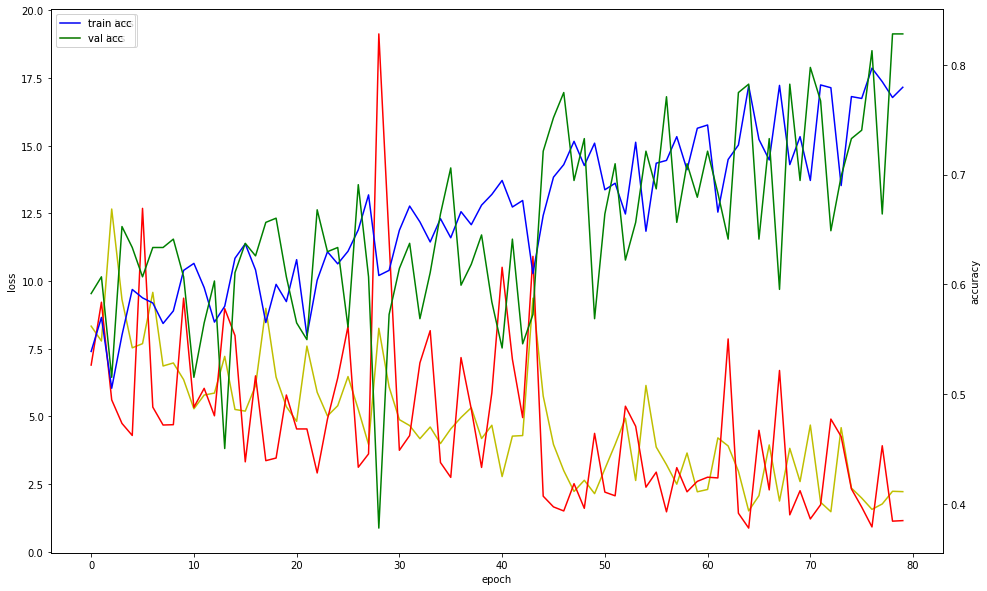

In [13]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [14]:
x_val.shape

(262, 30, 99)

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[139,  33],
        [ 12,  78]],

       [[156,   8],
        [ 32,  66]],

       [[184,   4],
        [  1,  73]]], dtype=int64)

In [16]:
np.argmax(y_pred, axis=1)

array([0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0,
       1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 1,
       0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0,
       2, 0, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 1, 0, 0,
       2, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0,
       0, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2, 0, 1,
       0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0,
       1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 0, 0,
       0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 2, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1],
      dtype=int64)